In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
prices = pd.read_csv('prices.csv')
prices = prices.dropna(subset=['rating'])
print(prices.columns)

Index(['platform', 'website', 'date', 'zipcode', 'rank', 'page', 'query',
       'prod_id', 'upc', 'product', 'manufacturer', 'model', 'price',
       'list_price', 'in_stock', 'max_qty', 'seller', 'arrives', 'shipping',
       'shipping_price', 'shipping_options', 'store_stock', 'store_address',
       'store_zip', 'store_price', 'weight', 'reviews', 'rating', 'quantity1',
       'quantity2', 'quantity3', 'quantity4', 'quantity5', 'ads'],
      dtype='object')


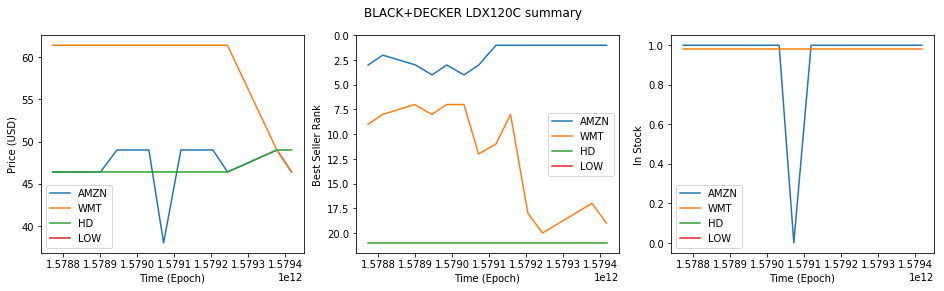

In [12]:
def create_plot(manuf,model,prices):
    platforms  = ['AMZN','WMT','HD','LOW']
    prices['new_rank'] =prices['rank'] + (prices['rank'] == 0)*21
    prod1 = prices[ (prices['manufacturer'] ==manuf) & (prices['model']==model) ]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    axes[1].set_ylim(22,0)
    
    stock_shift = 0
    
    for plat in platforms:
        prod1_plat = prod1[prod1['platform']==plat]
        prod1_plat = prod1_plat.sort_values('date')
        
        axes[0].plot(prod1_plat['date'],prod1_plat['price'],label=plat)
        axes[1].plot(prod1_plat['date'],prod1_plat['new_rank'],label=plat)
        axes[2].plot(prod1_plat['date'],prod1_plat['in_stock'] +stock_shift,label=plat)
    
        stock_shift = stock_shift -.02
    
    fig.suptitle("%s %s summary"%(manuf,model) )
    
    axes[0].set_xlabel('Time (Epoch)')
    axes[0].set_ylabel('Price (USD)')
    axes[0].legend()
    
    axes[1].set_xlabel('Time (Epoch)')
    axes[1].set_ylabel('Best Seller Rank') 
    axes[1].legend()
    
    axes[2].set_xlabel('Time (Epoch)')
    axes[2].set_ylabel('In Stock') 
    axes[2].legend()

    plt.show()


create_plot('BLACK+DECKER','LDX120C',prices)

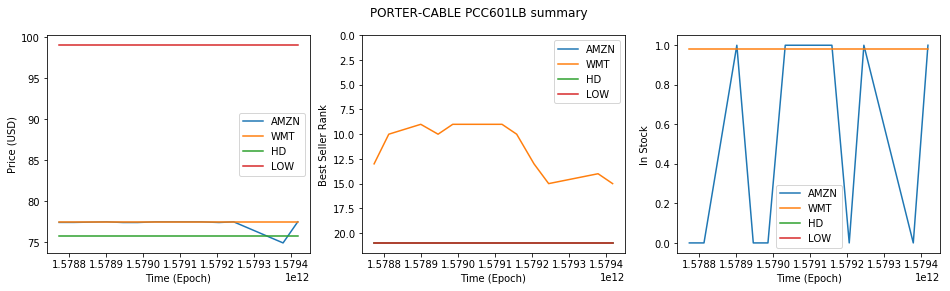

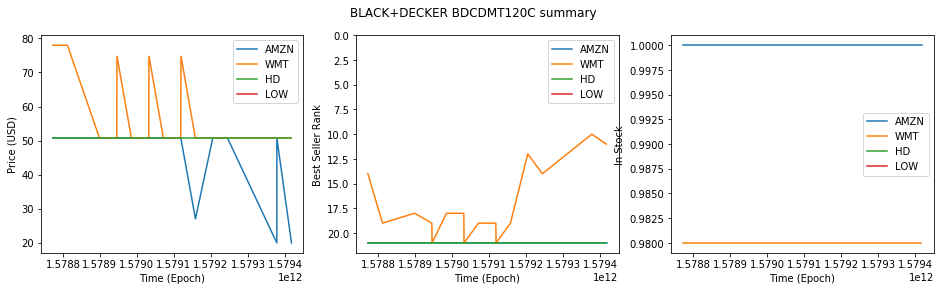

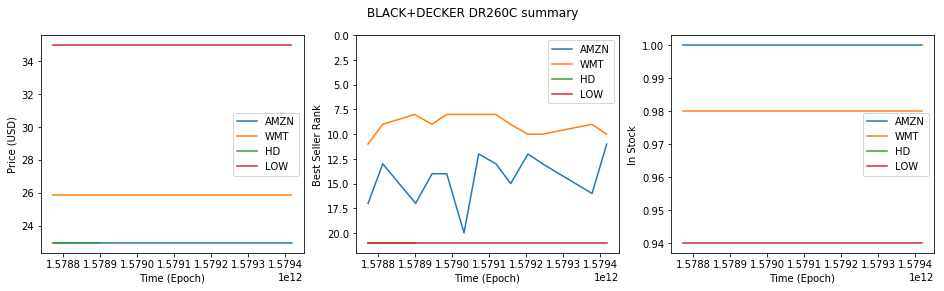

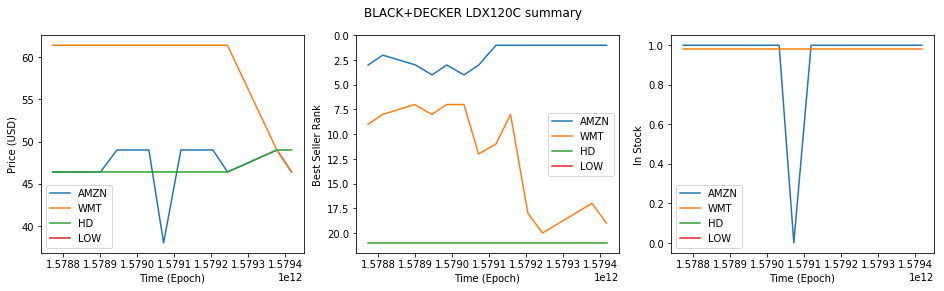

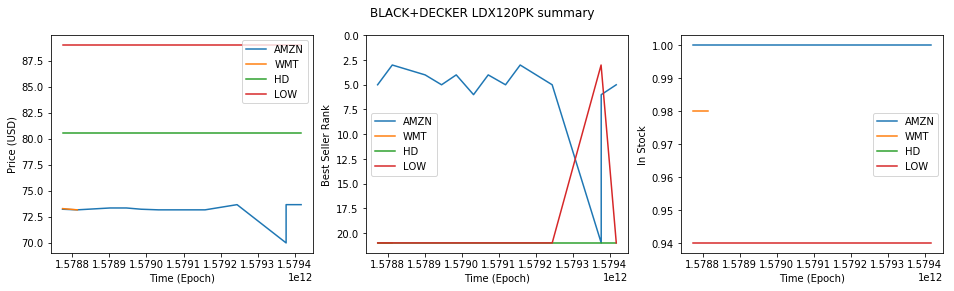

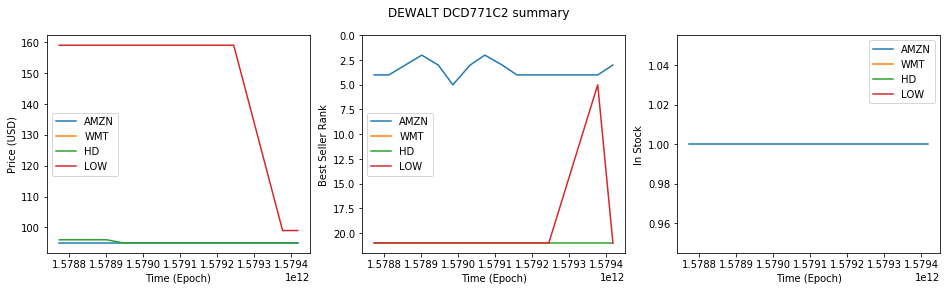

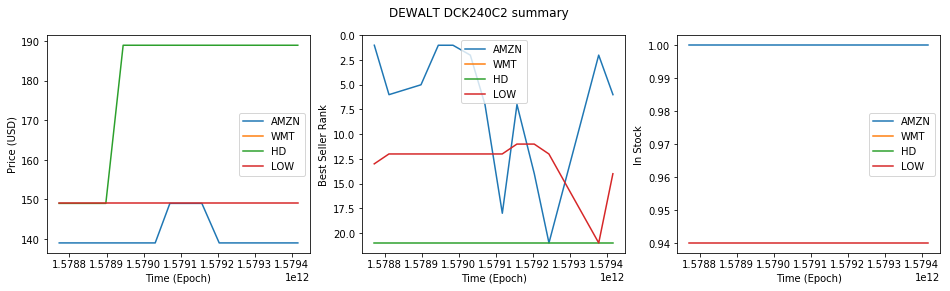

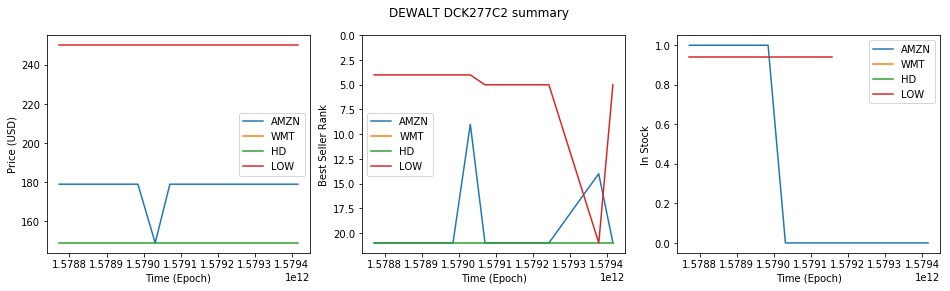

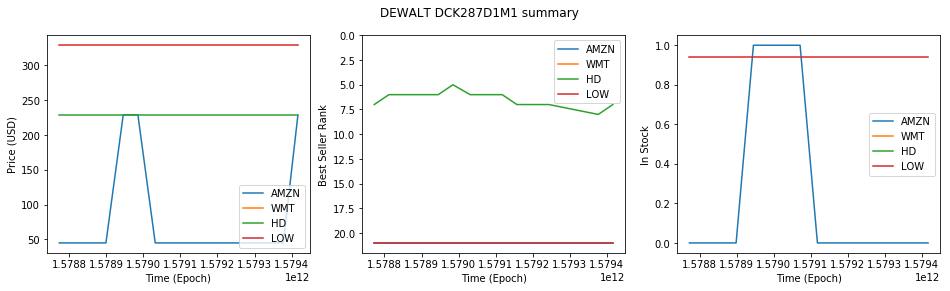

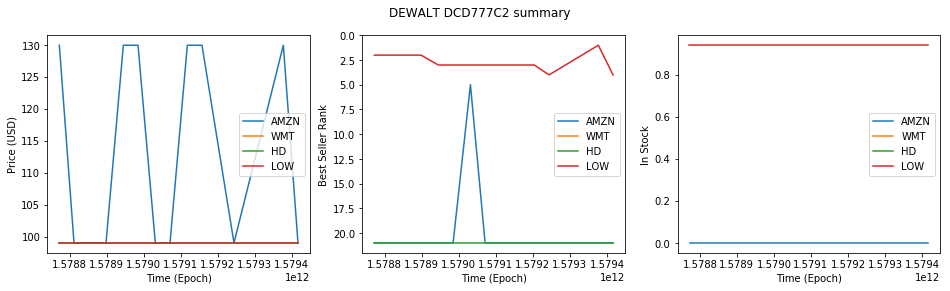

In [13]:
top_items = prices[['manufacturer','model']].groupby(['manufacturer','model']).size().reset_index()
top_items = top_items.nlargest(10, columns = 0)
for index, row in top_items.iterrows():
    create_plot(row['manufacturer'],row['model'],prices)